## **Data Preparing**

**Import Library and Load Data**
- Import Library ที่จำเป็น เช่น `torch`, `torchvision` `datasets` etc. 
- โหลดชุดข้อมูลจาก Hugging Face ชื่อ **plastic_detection_roboflow**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

dataset = load_dataset("tukey/plastic_detection_roboflow", split="train")

print(dataset)

print(dataset[0]['qa'])

Dataset({
    features: ['image', 'qa'],
    num_rows: 22075
})
[{'question': 'are there HDPE Plastic in the image?', 'answer': 'yes'}, {'question': 'are there Single-Use-Plastic in the image?', 'answer': 'no'}]


**Custom Dataset**
- สร้างคลาส `PlasticDataset` เพื่อ:
  - แปลงข้อมูลภาพเป็น Tensor
  - สร้าง multi-label vector จากคำถามในคอลัมน์ `qa`

In [2]:
# Custom Dataset
class PlasticDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        # plastic type 
        self.labels = [
            "PET Bottle",
            "HDPE Plastic",
            "Single layer Plastic",
            "Squeeze Tube",
            "UHT Box",
            "Single Use Plastic",
            "Multi layer Plastic",
            "bottle waste bow bag"
        ]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Check: URL or PIL Image
        img_data = self.dataset[idx]['image']

        # load img
        if isinstance(img_data, str):  # if URL
            response = requests.get(img_data)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:  # if PIL Image
            img = img_data.convert('RGB')

        # transform img
        if self.transform:
            img = self.transform(img)

        # create multi-label vector
        label = torch.zeros(len(self.labels))
        for qa in self.dataset[idx]['qa']:
            # matching question : self.labels
            clean_question = (
                qa['question']
                .replace("are there ", "")
                .replace(" in the image?", "")
                .replace("-", " ")
                .strip()
            )

            if qa['answer'] == 'yes' and clean_question in self.labels:
                label[self.labels.index(clean_question)] = 1
        
        return img, label

## **Data Processing and Splitting**

**Edit and Split Data**
- เพิ่ม **Data Augmentation** เพื่อปรับแต่งข้อมูลภาพ
- แบ่งข้อมูลเป็น **Train(70%), Validation(15%), Test(15%)**
- สร้าง **DataLoader** สำหรับโหลดข้อมูลใน **batch**

In [3]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),   
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# split: train, validation, test
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_split, valid_split, test_split = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# create Datasets
train_data = PlasticDataset(train_split, transform=transform)
valid_data = PlasticDataset(valid_split, transform=transform)
test_data = PlasticDataset(test_split, transform=transform)

# create DataLoadersS
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## **Model Configuration and Training**

**Model Setting**
- โหลดโมเดล ResNet-50 พร้อมค่าที่ฝึกมาก่อน (Pretrained)
- ปรับ Fully Connected Layer ให้ตรงกับจำนวนคลาสในชุดข้อมูล
- ตั้งค่า Loss Function (`BCEWithLogitsLoss`) และ Optimizer (`Adam`)

In [ ]:
# Load Model: Pretrained ResNet-50
model = models.resnet50(pretrained=True)

# change Fully Connected Layer
model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.labels))

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function
criterion = torch.nn.BCEWithLogitsLoss()  # ใช้สำหรับ Multi-label Classification

# optimizer: learning rate, (Regularization Techniques)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

**Training Model**
- วนลูปการฝึกโมเดล:
  - อัพเดตน้ำหนักด้วยการ backward
  - คำนวณค่า Loss สำหรับ Train และ Validation
  - ใช้ Early Stopping หาก Validation Loss ไม่ลดลงใน 3 epoch

In [ ]:
# Train

# early stopping
patience = 3  
best_valid_loss = float('inf')
epochs_without_improvement = 0

# setting
num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    avg_valid_loss = running_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

    # check early stopping
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        epochs_without_improvement = 0  
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break  

Epoch 1/10, Train Loss: 0.1842, Valid Loss: 0.1382
Epoch 2/10, Train Loss: 0.1396, Valid Loss: 0.1164
Epoch 3/10, Train Loss: 0.1244, Valid Loss: 0.1277
Epoch 4/10, Train Loss: 0.1157, Valid Loss: 0.1324
Epoch 5/10, Train Loss: 0.1057, Valid Loss: 0.0993
Epoch 6/10, Train Loss: 0.0989, Valid Loss: 0.0920
Epoch 7/10, Train Loss: 0.0925, Valid Loss: 0.0956
Epoch 8/10, Train Loss: 0.0874, Valid Loss: 0.0911
Epoch 9/10, Train Loss: 0.0834, Valid Loss: 0.0781
Epoch 10/10, Train Loss: 0.0806, Valid Loss: 0.0767


## **Evaluation**

**Train loss VS Validation loss**
- สร้างกราฟแสดง Train Loss และ Validation Loss ในแต่ละ Epoch
- ใช้เพื่อประเมินการ overfitting หรือ underfitting

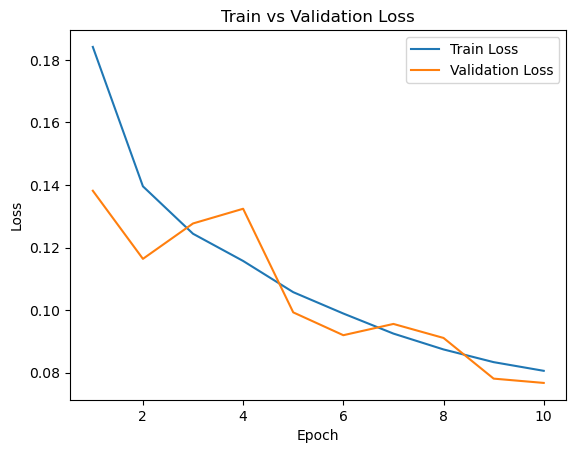

In [ ]:
# Plot Loss

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

**Testing Model Performance**
- ทดสอบโมเดลในชุดข้อมูลทดสอบ
- คำนวณค่า Accuracy, Precision, Recall และ F1 Score ในรูปแบบ Micro, Macro และ Weighted

In [13]:
#test
model.eval()
test_loss = 0.0
all_predictions = []
all_labels = []
correct_predictions = 0
total_samples = 0
accuracy = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect Data for Calculate Metrics 
        predicted_labels = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_predictions.append(predicted_labels)
        all_labels.append(labels.cpu().numpy())

        # คำนวณจำนวนการทำนายที่ถูกต้อง
        correct_predictions += (predicted_labels == labels).all(dim=1).sum().item()
        total_samples += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# รวมผลลัพธ์ทั้งหมด
all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)

# Precision, Recall, F1 Score
micro_f1 = f1_score(all_labels, all_predictions, average='micro')
macro_f1 = f1_score(all_labels, all_predictions, average='macro')
weighted_f1 = f1_score(all_labels, all_predictions, average='weighted')

micro_precision = precision_score(all_labels, all_predictions, average='micro')
macro_precision = precision_score(all_labels, all_predictions, average='macro')
weighted_precision = precision_score(all_labels, all_predictions, average='weighted')

micro_recall = recall_score(all_labels, all_predictions, average='micro')
macro_recall = recall_score(all_labels, all_predictions, average='macro')
weighted_recall = recall_score(all_labels, all_predictions, average='weighted')

# Result Metrics
print(f"Precision (Micro): {micro_precision:.4f}")
print(f"Recall (Micro): {micro_recall:.4f}")
print(f"F1 Score (Micro): {micro_f1:.4f}")

print(f"Precision (Macro): {macro_precision:.4f}")
print(f"Recall (Macro): {macro_recall:.4f}")
print(f"F1 Score (Macro): {macro_f1:.4f}")

print(f"Precision (Weighted): {weighted_precision:.4f}")
print(f"Recall (Weighted): {weighted_recall:.4f}")
print(f"F1 Score (Weighted): {weighted_f1:.4f}")

Test Loss: 0.0628
Test Accuracy: 87.89%
Precision (Micro): 0.9456
Recall (Micro): 0.8970
F1 Score (Micro): 0.9207
Precision (Macro): 0.8289
Recall (Macro): 0.7884
F1 Score (Macro): 0.8070
Precision (Weighted): 0.9484
Recall (Weighted): 0.8970
F1 Score (Weighted): 0.9208


c:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\anaconda3\lib\s

## **Prediction Visualize**

**Show Predictions**
- ใช้ฟังก์ชัน `show_prediction` เพื่อ:
  - แสดงภาพที่ใช้พยากรณ์ พร้อมป้ายกำกับจริง (Ground Truth) และผลการพยากรณ์จากโมเดล
  - ใช้ฟังก์ชัน `adjust_true_labels` และ `adjust_predictions` เพื่อ:
    - รวมประเภทขยะที่ไม่สามารถรีไซเคิลได้เป็น "Non Recyclable"
    - ลบค่าป้ายกำกับที่ซ้ำกัน
  - ใช้ค่าความน่าจะเป็น (probabilities) จากโมเดลในการกำหนดผลลัพธ์
  - แสดงผลบนภาพด้วยชื่อป้ายกำกับที่คาดการณ์และป้ายกำกับจริง

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


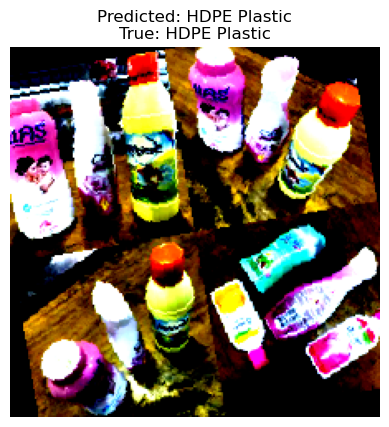

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


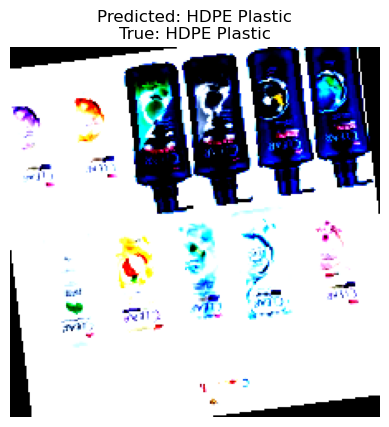

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.4134207].


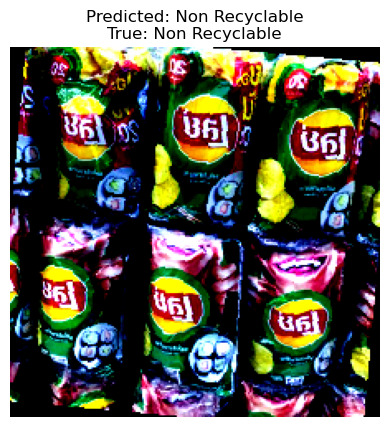

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..1.8905448].


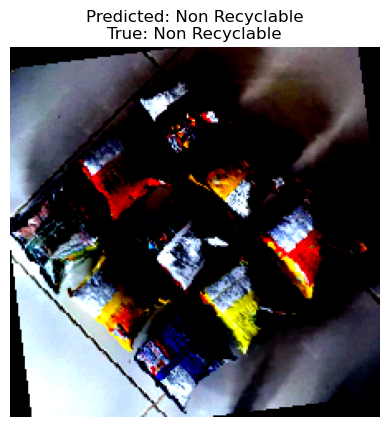

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].


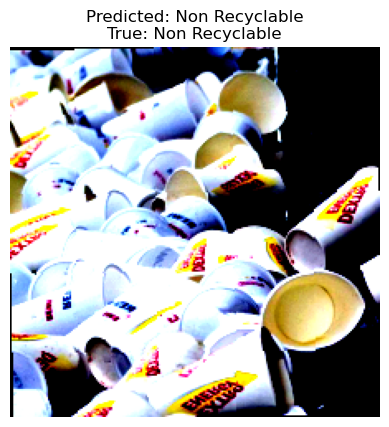

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.9776908].


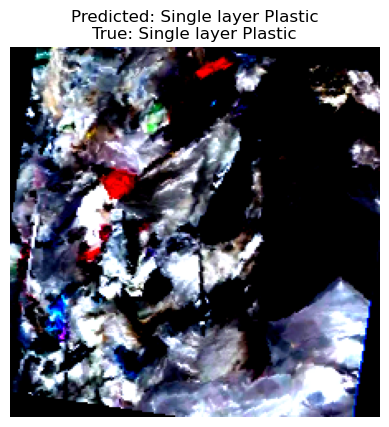

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.535425].


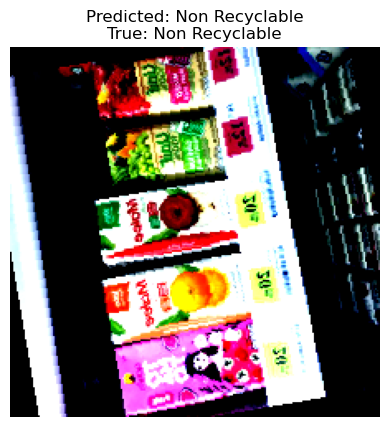

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].


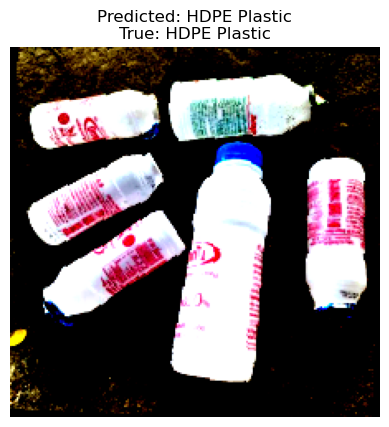

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


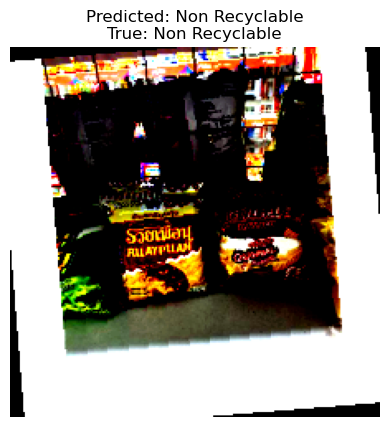

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..1.8721637].


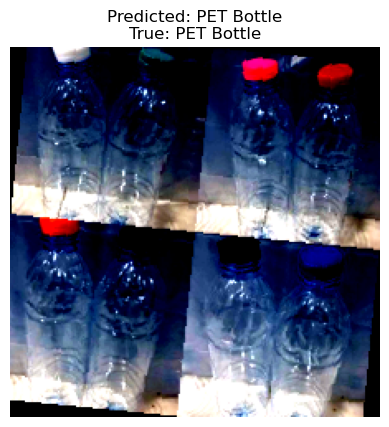

In [11]:
def adjust_true_labels(true_classes):
    # แทนคำใน true_classes ด้วย "Non Recyclable" ถ้าเป็นประเภทที่ไม่สามารถรีไซเคิลได้
    non_recyclables = {"UHT Box", "Single Use Plastic", "Multi layer Plastic", "bottle waste bow bag"}
    adjusted_classes = ["Non Recyclable" if cls in non_recyclables else cls for cls in true_classes]
    return list(set(adjusted_classes))  # ลบค่าซ้ำ

def adjust_predictions(predicted_classes):
    # แทนคำใน predicted_classes ด้วย "Non Recyclable" ถ้าเป็นประเภทที่ไม่สามารถรีไซเคิลได้
    non_recyclables = {"UHT Box", "Single Use Plastic", "Multi layer Plastic", "bottle waste bow bag"}
    adjusted_classes = ["Non Recyclable" if cls in non_recyclables else cls for cls in predicted_classes]
    return list(set(adjusted_classes))  # ลบค่าซ้ำ

def show_prediction(image, true_labels, model, labels):
    model.eval()  

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # batch (1)
        output = model(image)
        predictions = torch.sigmoid(output).squeeze()  # ใช้ sigmoid เพื่อแปลงออกเป็นค่า 0-1 สำหรับ multi-label
        predicted_labels = predictions > 0.5  # ถ้าค่ามากกว่า 0.5 ให้ถือว่าเป็น 'yes'

    # แปลงป้ายกำกับจริงและป้ายกำกับที่ทำนาย
    predicted_classes = [labels[i] for i in range(len(labels)) if predicted_labels[i]]
    predicted_classes = adjust_predictions(predicted_classes) 
    true_classes = [labels[i] for i in range(len(labels)) if true_labels[i]]
    true_classes = adjust_true_labels(true_classes)  

    # ตรวจสอบและแปลงภาพ
    image = image.squeeze(0).cpu()  # ลบ batch dimension
    image = image.permute(1, 2, 0).numpy()  # แปลงจาก (C, H, W) เป็น (H, W, C)

    plt.imshow(image)  # แปลงภาพจาก Tensor to numpy array
    plt.axis('off')

    plt.title(f'Predicted: {", ".join(predicted_classes)}\nTrue: {", ".join(true_classes)}')
    plt.show()

start_idx = 90
end_idx = 100

for idx in range(start_idx, end_idx):  
    image, true_labels = test_data[idx] 
    show_prediction(image, true_labels, model, train_data.labels)